In [ ]:
from google.colab import files
import zipfile
import os
from google.colab import drive

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary
from PIL import Image

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import cv2
import numpy as np
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms.functional as FF
from torchvision.transforms.functional import convert_image_dtype
from PIL import ImageOps

In [ ]:
drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The model will be running on cuda:0 device


In [ ]:
model_yncat = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_yncat.aux_logits = False
for param in model_yncat.parameters():
    param.requires_grad = False

# model_yncat.fc = nn.Sequential(
#     nn.Linear(model_yncat.fc.in_features, 10),
#     nn.Linear(10,2)
# )

model_yncat.fc = nn.Sequential(
    nn.Linear(model_yncat.fc.in_features, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 2),
    nn.Sigmoid()
)

In [ ]:
model_yncat = model_yncat.cuda()
summary(model_yncat, (3, 299, 299))
model_yncat.eval()

In [ ]:
weights=torch.load("/content/drive/MyDrive/model-yes-no-cat.pth")
model_yncat.load_state_dict(weights)
model_yncat = model_yncat.cuda()
model_yncat = model_yncat.to(device)

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import cv2
import numpy as np
from torchvision.models.segmentation import fcn_resnet50
import torchvision.transforms.functional as FF
from torchvision.transforms.functional import convert_image_dtype

In [ ]:
model_se = fcn_resnet50(pretrained=True, progress=False)
model_se = model_se.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
data = zipfile.ZipFile('/content/drive/MyDrive/cat_dataset.zip','r')
data.extractall('/dataset')
data.close()

dataset_sample = datasets.ImageFolder(
    root = '/dataset/cat_dataset'
)

In [ ]:
transform_0 = transforms.Compose([
    transforms.ToTensor()
])

def custom_collate(batch):
    data = [transform_0(img) for img, label in batch]
    target = torch.LongTensor([label for img, label in batch])
    return {'data': data, 'target': target}

dataloader = DataLoader(dataset_sample, batch_size=1, shuffle=True, collate_fn=custom_collate)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

def resize_image(img,target_size=(299, 299)):
    width, height = img.size
    padding_width = max(0, (target_size[0] - width) // 2)
    padding_height = max(0, (target_size[1] - height) // 2)

    padded_img = ImageOps.expand(img, border=(padding_width, padding_height), fill='white')

    resized_img = padded_img.resize(target_size, Image.ANTIALIAS)

    return resized_img

def semantic(img):
    resized_img = resize_image(img)
    cat_img = transform(resized_img)
    batch_int = torch.stack([cat_img])
    batch = convert_image_dtype(batch_int, dtype=torch.float)

    normalized_batch = FF.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    output = model_se(normalized_batch)['out']

    sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
    normalized_masks = torch.nn.functional.softmax(output, dim=1)
    class_dim = 1
    boolean_cat_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])
    output_img = boolean_cat_masks*cat_img
    return output_img

def cat_or_not(inp_img):
    # inp_img_ync = cv2.resize(inp_img, (299, 299))
    # inp_img_ync = np.transpose(inp_img_ync, (2, 0, 1))
    # inp_img_ync = torch.from_numpy(inp_img_ync)
    # inp_img_ync = inp_img.unsqueeze(0)
    # inp_img_ync = np.array(inp_img)
    # inp_img_ync = np.expand_dims(inp_img_ync, axis=0)
    data_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
    ])
    inp_img_ync = data_transform(inp_img)
    inp_img_ync = inp_img_ync.to(device)
    inp_img_ync = inp_img_ync.unsqueeze(0)
    # print(inp_img_ync)
    # print(inp_img_ync.shape)
    pred = model_yncat(inp_img_ync)
    _, predicted_class = torch.max(pred, 1)
    return predicted_class.item()

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def sample_data(class_no):
    c = 0
    lis_im = []
    for i, batch in enumerate(dataloader):
        if batch['target'].item() == class_no:
            image = transforms.ToPILImage()(batch['data'][0])
            lis_im.append(image)
            c += 1
        if c > 5:
            break
    return lis_im

def process(inp_img):
    class_no = cat_or_not(inp_img)
    if (class_no==1) :
        return "Not a cat",[]
    se_img = semantic(inp_img)
    se_img = se_img.to(device)
    pred = model_bre(se_img.unsqueeze(0))
    _, predicted_class = torch.max(pred, 1)
    breed_mapping = {0: 'bengal', 1: 'domestic_shorthair', 2: 'maine_coon', 3: 'ragdoll', 4: 'siamese'}
    lis_im = sample_data(predicted_class.item())

    predicted_breed = breed_mapping.get(predicted_class.item())
    return predicted_breed, lis_im


In [ ]:
model_bre = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_bre.aux_logits = False
for param in model_bre.parameters():
    param.requires_grad = False

model_bre.fc = nn.Sequential(
    nn.Linear(model_bre.fc.in_features, 10),
    nn.Linear(10,5)
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_bre = model_bre.cuda()
summary(model_bre, (3, 299, 299))
model_bre.eval()

In [ ]:
#weights=torch.load("/content/drive/MyDrive/82p3-0p61-In2048t10t5.pth")
weights=torch.load("/content/drive/MyDrive/model_breed_classify.pth")
model_bre.load_state_dict(weights)
model_bre = model_bre.cuda()
model_bre = model_bre.to(device)

# test 1

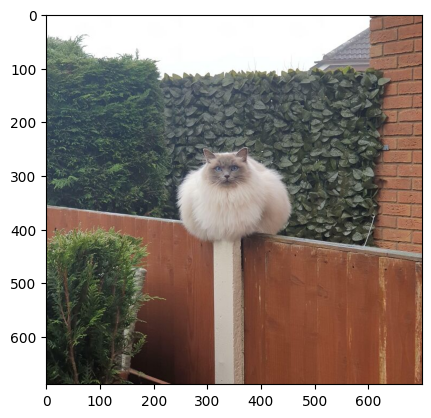

In [ ]:
demo_img_1 = Image.open('/content/drive/MyDrive/ragdoll-1.jpg')
plt.imshow(demo_img_1)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


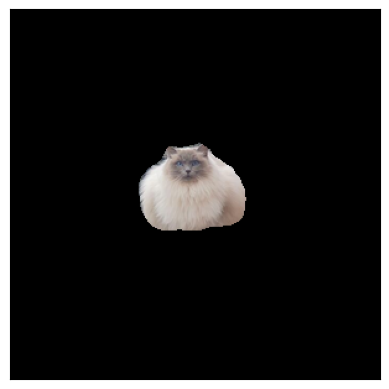

In [ ]:
se_demo_img_1 = semantic(demo_img_1)
show(se_demo_img_1)

In [ ]:
class_name,lis_im_1 = process(demo_img_1)
print(class_name)
if lis_im_1 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_1[i])

Not a cat


# test 2

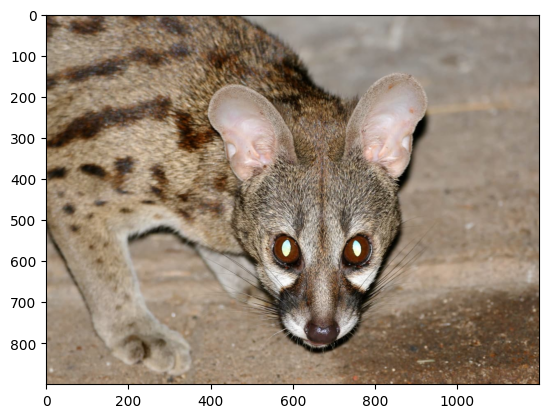

In [ ]:
demo_img_2 = Image.open('/content/drive/MyDrive/not-cat-1.jpg')
plt.imshow(demo_img_2)

<ipython-input-59-4ea4bff1dc1f>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


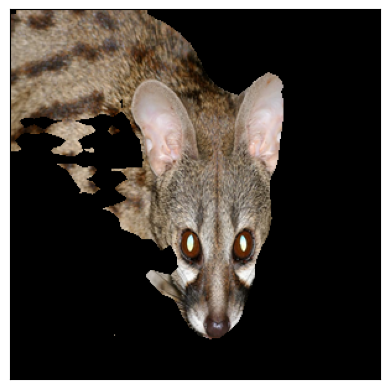

In [ ]:
se_demo_img_2 = semantic(demo_img_2)
show(se_demo_img_2)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


siamese


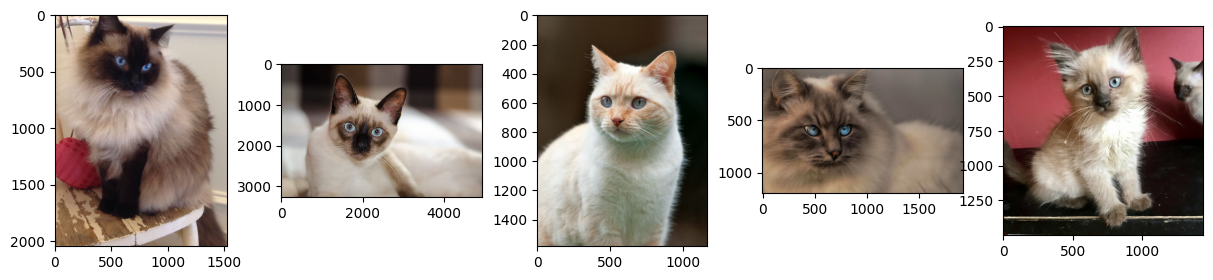

In [ ]:
class_name,lis_im_2 = process(demo_img_2)
print(class_name)
if lis_im_2 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_2[i])

# test 3

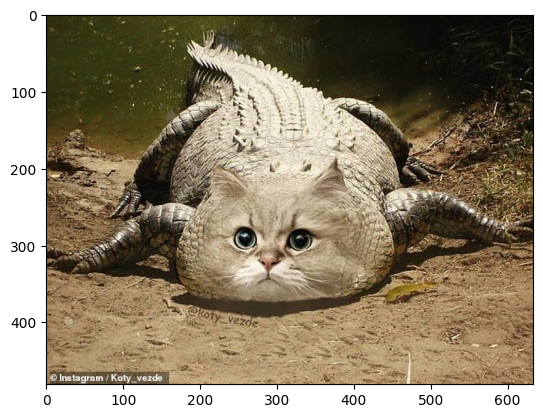

In [ ]:
demo_img_3 = Image.open('/content/drive/MyDrive/not-cat-2.jpg')
plt.imshow(demo_img_3)

<ipython-input-59-4ea4bff1dc1f>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


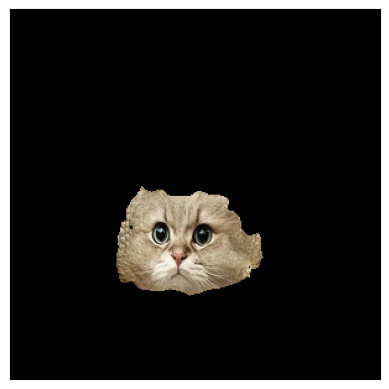

In [ ]:
se_demo_img_3 = semantic(demo_img_3)
show(se_demo_img_3)

In [ ]:
class_name,lis_im_3 = process(demo_img_3)
print(class_name)
if lis_im_3 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_3[i])

Not a cat


# test 4

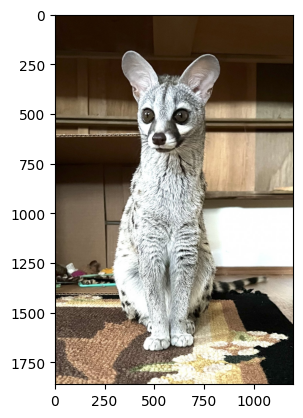

In [ ]:
demo_img_4 = Image.open('/content/drive/MyDrive/not-cat-3.jpg')
plt.imshow(demo_img_4)

<ipython-input-59-4ea4bff1dc1f>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


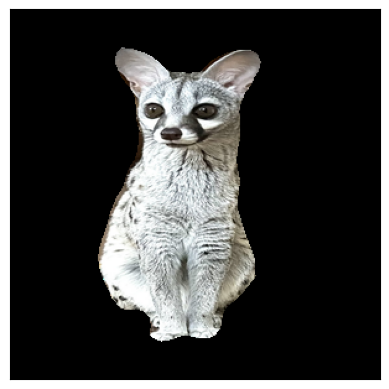

In [ ]:
se_demo_img_4 = semantic(demo_img_4)
show(se_demo_img_4)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


siamese


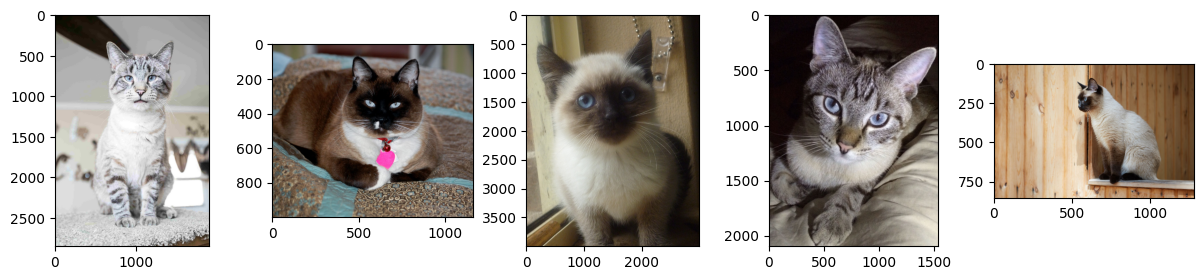

In [ ]:
class_name,lis_im_4 = process(demo_img_4)
print(class_name)
if lis_im_4 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_4[i])

# test 5

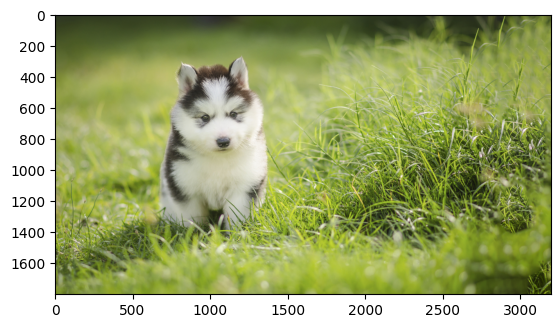

In [ ]:
demo_img_5 = Image.open('/content/drive/MyDrive/not-cat-4.jpg')
plt.imshow(demo_img_5)

<ipython-input-59-4ea4bff1dc1f>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


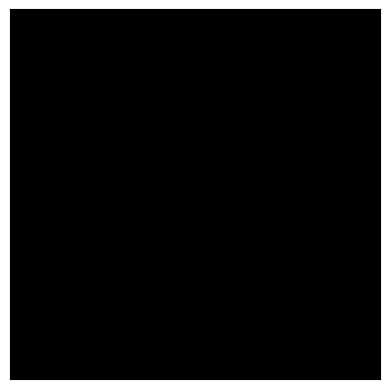

In [ ]:
se_demo_img_5 = semantic(demo_img_5)
show(se_demo_img_5)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


bengal


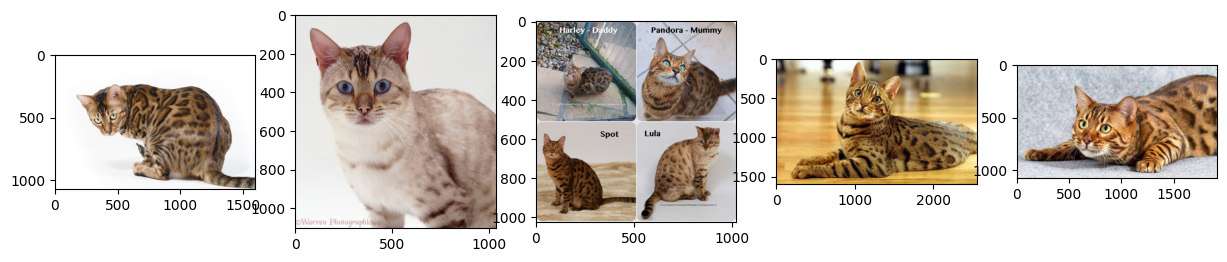

In [ ]:
class_name,lis_im_5 = process(demo_img_5)
print(class_name)
if lis_im_5 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_5[i])

# test 6

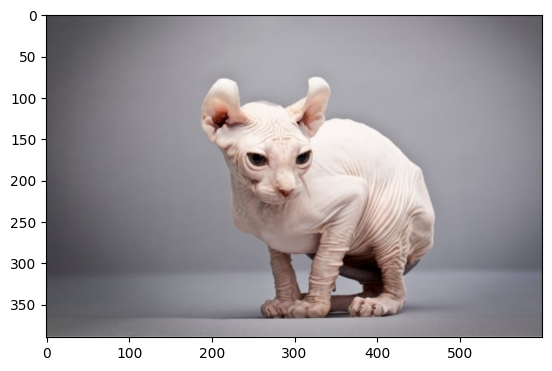

In [ ]:
demo_img_6 = Image.open('/content/drive/MyDrive/cat-2.jpg')
plt.imshow(demo_img_6)

<ipython-input-59-4ea4bff1dc1f>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


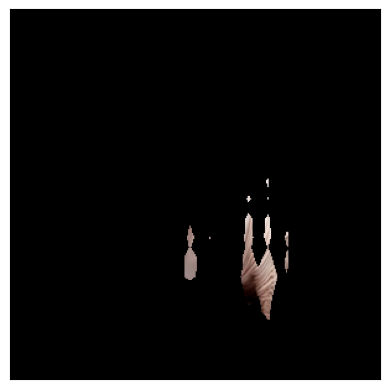

In [ ]:
se_demo_img_6 = semantic(demo_img_6)
show(se_demo_img_6)

In [ ]:
class_name,lis_im_6 = process(demo_img_6)
print(class_name)
if lis_im_6 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_6[i])

Not a cat


# test 7

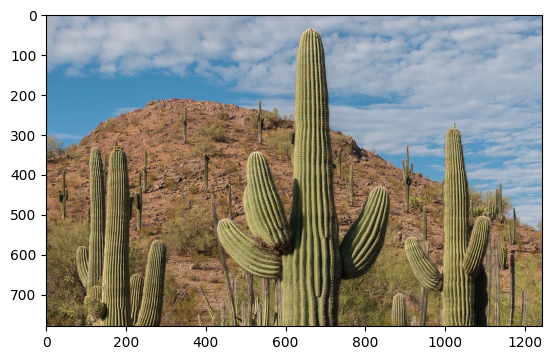

In [ ]:
demo_img_7 = Image.open('/content/drive/MyDrive/not-cat-6.jpg')
plt.imshow(demo_img_7)

In [ ]:
class_name,lis_im_7 = process(demo_img_7)
print(class_name)
if lis_im_7 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_7[i])

Not a cat


# test8

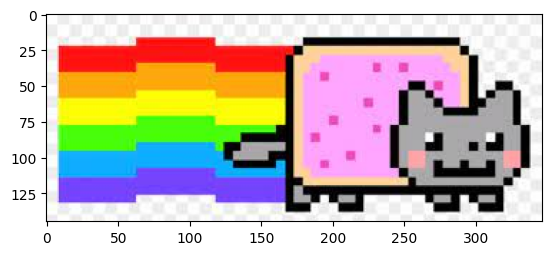

In [ ]:
demo_img_8 = Image.open('/content/drive/MyDrive/cat-1.jpg')
plt.imshow(demo_img_8)

In [ ]:
class_name,lis_im_8 = process(demo_img_8)
print(class_name)
if lis_im_8 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_8[i])

Not a cat


# test 9

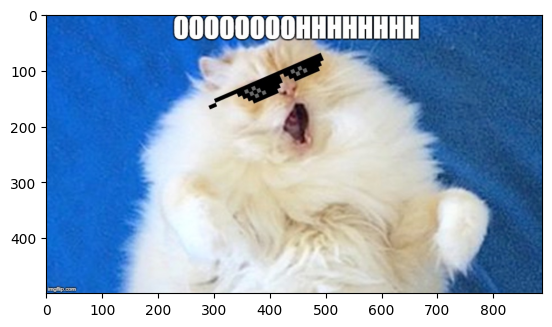

In [ ]:
demo_img_9 = Image.open('/content/drive/MyDrive/ragdoll-2.jpg')
plt.imshow(demo_img_9)

In [ ]:
class_name,lis_im_9 = process(demo_img_9)
print(class_name)
if lis_im_9 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_9[i])

Not a cat


# test 10

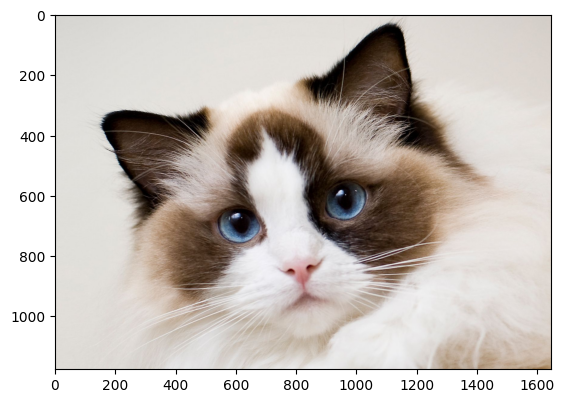

In [ ]:
demo_img_10 = Image.open('/content/drive/MyDrive/ragdoll-3.jpg')
plt.imshow(demo_img_10)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


ragdoll


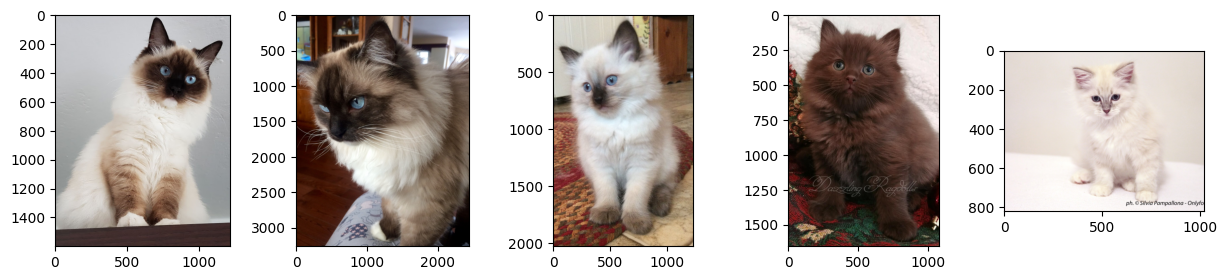

In [ ]:
class_name,lis_im_10 = process(demo_img_10)
print(class_name)
if lis_im_10 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_10[i])

# test 11

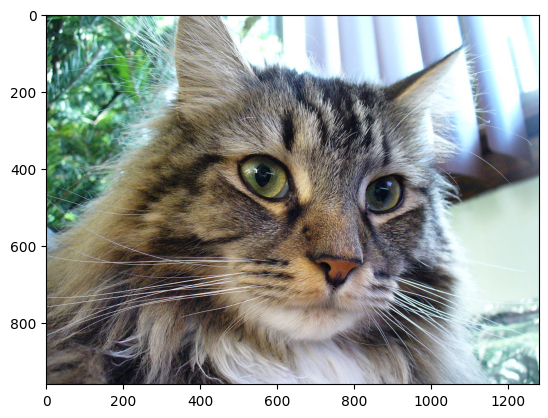

In [ ]:
demo_img_11 = Image.open('/content/drive/MyDrive/maine_coon-1.jpg')
plt.imshow(demo_img_11)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


maine_coon


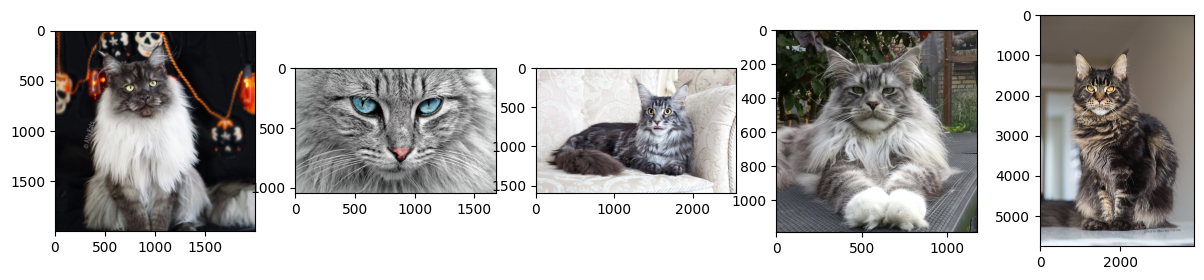

In [ ]:
class_name,lis_im_11 = process(demo_img_11)
print(class_name)
if lis_im_11 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_11[i])

# test 12


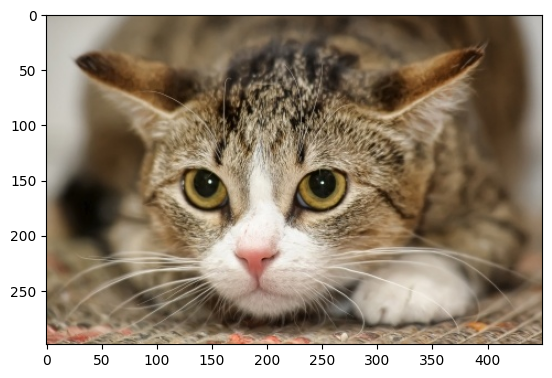

In [ ]:
demo_img_12 = Image.open('/content/drive/MyDrive/domestic_shorthair-1.jpg')
plt.imshow(demo_img_12)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


domestic_shorthair


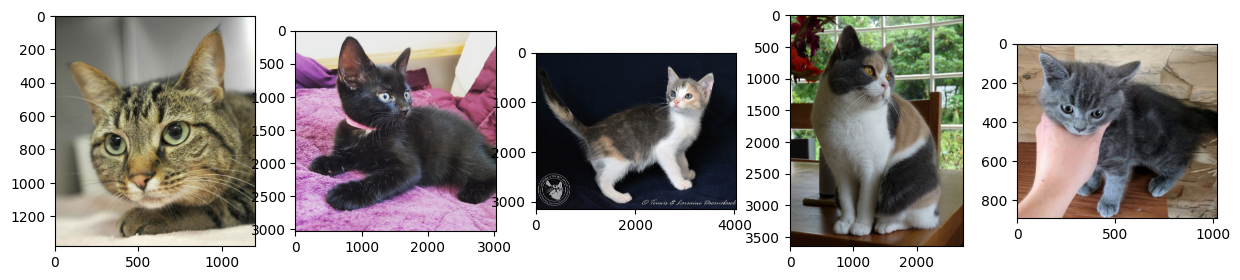

In [ ]:
class_name,lis_im_12 = process(demo_img_12)
print(class_name)
if lis_im_12 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_12[i])

# test 13

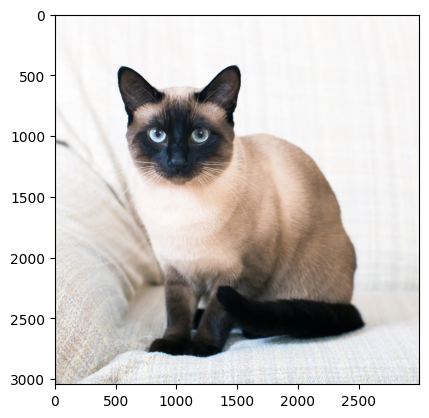

In [ ]:
demo_img_13 = Image.open('/content/drive/MyDrive/siamese-1.jpg')
plt.imshow(demo_img_13)

<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


siamese


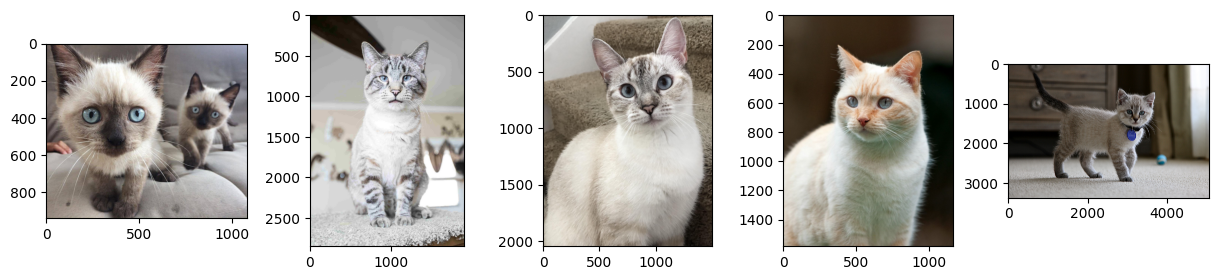

In [ ]:
class_name,lis_im_13 = process(demo_img_13)
print(class_name)
if lis_im_13 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_13[i])

# test 14

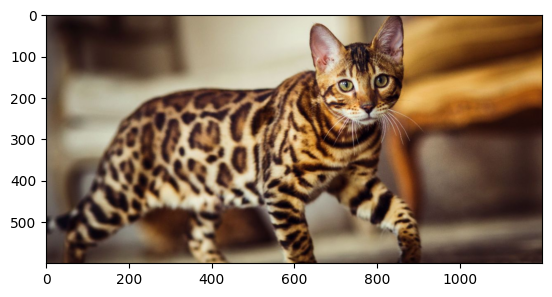

In [ ]:
demo_img_14 = Image.open('/content/drive/MyDrive/bengal-1.jpg')
plt.imshow(demo_img_14)


<ipython-input-108-abc14b6ad870>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = padded_img.resize(target_size, Image.ANTIALIAS)


bengal


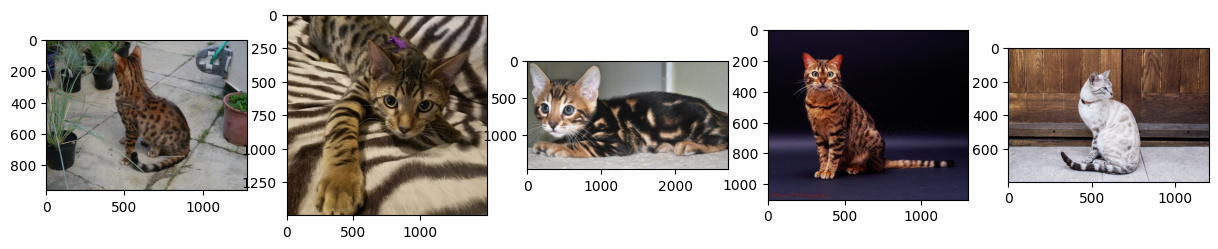

In [ ]:
class_name,lis_im_14 = process(demo_img_14)
print(class_name)
if lis_im_14 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_14[i])

# test 15

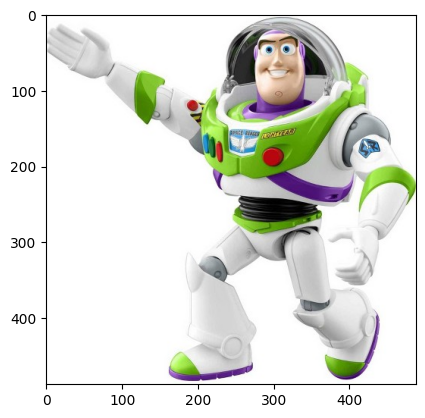

In [ ]:
demo_img_15 = Image.open('/content/drive/MyDrive/not-cat-5.jpg')
plt.imshow(demo_img_15)

In [ ]:
class_name,lis_im_15 = process(demo_img_15)
print(class_name)
if lis_im_15 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_15[i])

Not a cat


# test 16

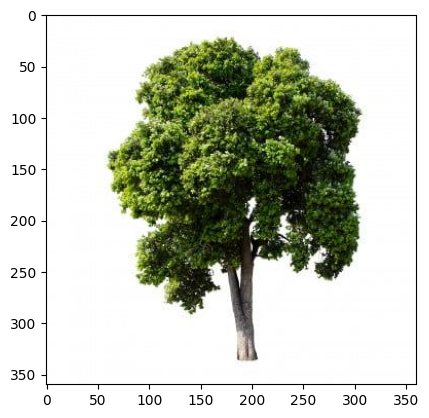

In [ ]:
demo_img_16 = Image.open('/content/drive/MyDrive/not-cat-7.jpg')
plt.imshow(demo_img_16)

In [ ]:
class_name,lis_im_16 = process(demo_img_16)
print(class_name)
if lis_im_16 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_16[i])

Not a cat


# test 17

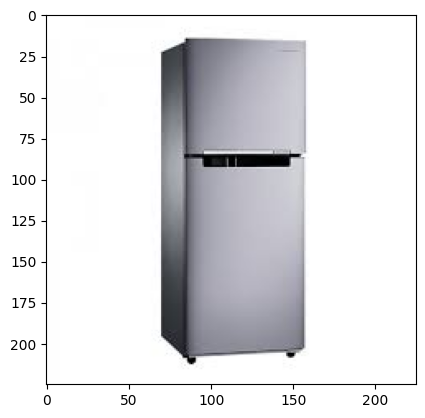

In [ ]:
demo_img_17 = Image.open('/content/drive/MyDrive/not-cat-8.jpg')
plt.imshow(demo_img_17)

In [ ]:
class_name,lis_im_17 = process(demo_img_17)
print(class_name)
if lis_im_17 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_17[i])

Not a cat


# test 18

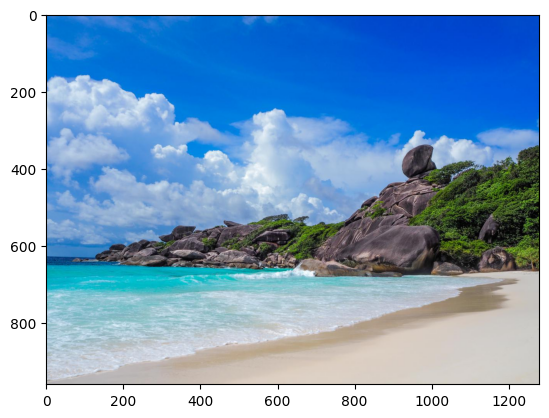

In [ ]:
demo_img_18 = Image.open('/content/drive/MyDrive/not-cat-9.jpg')
plt.imshow(demo_img_18)

In [ ]:
class_name,lis_im_18 = process(demo_img_18)
print(class_name)
if lis_im_18 != []:
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(lis_im_18[i])

Not a cat
